# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [9]:
# dataframes 
import numpy as np
import pandas as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *

# para hacer matriz confusion
from sklearn.metrics import confusion_matrix

In [10]:
def confusion(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    return matriz
    # display_matriz = ConfusionMatrixDisplay(confusion_matrix=matriz)
    # display_matriz.plot()
    # plt.show()


#                 Predicción Positivo    Predicción Negativo
# Actual Positivo        TP                    FN
# Actual Negativo        FP                    TN
def plot_matriz(matrix, porcentaje, normalizado):
    classes = ["VBF", "ggF"]

    # normalizo los datos dependiendo si son vbf o ggf
    if normalizado == True:
        n_datos_vbf = matrix[0][0]+matrix[0][1]
        n_datos_ggf = matrix[1][0]+matrix[1][1]
        matriz_confusion = [[matrix[0][0]/n_datos_vbf,matrix[0][1]/n_datos_vbf],
                            [matrix[1][0]/n_datos_ggf,matrix[1][1]/n_datos_ggf]]
    else: 
        matriz_confusion = matrix


    # Crear una figura y un subplot
    plt.figure(figsize=(6, 6)) # para que no se vea tan grande
    plt.matshow(matriz_confusion, cmap="Blues", fignum=1)

    # Agregar etiquetas
    for i in range(2):
        for j in range(2):
            plt.text(j, i, np.format_float_scientific(matriz_confusion[i][j], precision=3), ha="center", va="center", fontsize=14, color="r")

    # Configuración de ejes y etiquetas
    plt.xticks([0, 1], classes)
    plt.yticks([0, 1], classes)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Valor Real", fontsize=12)
    plt.title("Matriz de Confusión", fontsize=14)

    # Mostrar el gráfico
    plt.show()

def plot_confusion_barras(matrix):

    # normalizo los datos de vbf y ggf
    n_datos_vbf = matrix[0][0]+matrix[0][1]
    n_datos_ggf = matrix[1][0]+matrix[1][1]
    datos = [matrix[0][0]/n_datos_vbf,matrix[0][1]/n_datos_vbf,
            matrix[1][0]/n_datos_ggf,matrix[1][1]/n_datos_ggf]

    # creo un dataframe para realizar el gráfico más facilmente con seaborn
    matriz_graficar = {'valor normalizado':datos,
                       'origen real':["VBF", "VBF", "ggF", "ggF"],
                       'clasificado como':["VBF", "ggf", "VBF", "ggf"],}
    df_matriz = pd.DataFrame(matriz_graficar)

    # realizo el gráfico
    plt.figure(figsize=(6, 6)) # para que no se vea tan grande
    ax = sns.barplot(data = df_matriz,
                x='clasificado como', 
                y ='valor normalizado',
                hue = "origen real",
                )
    
    # Agregar los valores encima de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                    textcoords='offset points')
    
    ax.legend(title="Origen Real", loc="upper center")

    plt.show()

# MAIN

In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_cortes.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


njet30           mjj            MET   
origin df_name                                                            
VBF    samples/VBF/frvz_vbf_500757       2  1.316194e+06  177043.093750  \
       samples/VBF/frvz_vbf_500757       7  2.287880e+06  101195.085938   
       samples/VBF/frvz_vbf_500757       2  1.568506e+06  130909.734375   
       samples/VBF/frvz_vbf_500757       4  4.717408e+05  491291.656250   
       samples/VBF/frvz_vbf_500757       8  1.150060e+06  115439.734375   
...                                    ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893       1 -9.990000e+02   40554.480469   
       samples/ggF/frvz_ggf_508893       3  2.406892e+05   76802.445312   
       samples/ggF/frvz_ggf_508893       2  1.434225e+05   26644.656250   
       samples/ggF/frvz_ggf_508893       0 -9.990000e+02   10709.070312   
       samples/ggF/frvz_ggf_508893       0 -9.990000e+02   10808.947266   

                                    scale1fb    intLumi  
origin df_name                                           
VBF    samples/VBF/frvz_vbf_500757  0.000486  44.299999  
       samples/VBF/frvz_vbf_500757  0.000502  44.299999  
       samples/VBF/frvz_vbf_500757  0.000429  44.299999  
       samples/VBF/frvz_vbf_500757  0.000531  44.299999  
       samples/VBF/frvz_vbf_500757  0.000014  44.299999  
...                                      ...        ...  
ggF    samples/ggF/frvz_ggf_508893  0.028479  58.450001  
       samples/ggF/frvz_ggf_508893  0.029882  58.450001  
       samples/ggF/frvz_ggf_508893  0.029517  58.450001  
       samples/ggF/frvz_ggf_508893  0.029929  58.450001  
       samples/ggF/frvz_ggf_508893  0.030318  58.450001  

[4628576 rows x 5 columns]

In [16]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_cortes = df_all_cut
df_cortes = df_cortes.droplevel('df_name')
df_cortes = df_cortes.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_cortes = df_cortes.reset_index(level='origin')
df_cortes = pd.get_dummies(df_cortes, columns=['origin'], dtype=int)

# creo los 2 filtros para vbf, si ambos son ciertos, es vbf (1) si no, no es vbf (0)
filtro_MET = df_cortes["MET"] >= 225000
filtro_mjj = df_cortes["mjj"] >= 1000000
df_cortes['pred_VBF'] = np.where(filtro_MET & filtro_mjj, 1, 0)

df_cortes

Numero eventos antes: 59024
Corte: njet30 entre [1, inf]
Numero eventos antes: 59024 



,mjj,MET,origin_VBF,origin_ggF,pred_VBF
0,1.316194e+06,177043.093750,1,0,0
1,2.287880e+06,101195.085938,1,0,0
2,1.568506e+06,130909.734375,1,0,0
3,4.717408e+05,491291.656250,1,0,0
4,1.150060e+06,115439.734375,1,0,0
...,...,...,...,...,...
2012571,8.682021e+04,36471.000000,0,1,0
2012572,6.930484e+04,5845.552246,0,1,0
2012573,5.065558e+05,27214.392578,0,1,0
2012574,2.406892e+05,76802.445312,0,1,0


In [17]:
matriz = confusion_matrix(df_cortes["origin_VBF"], df_cortes["pred_VBF"])

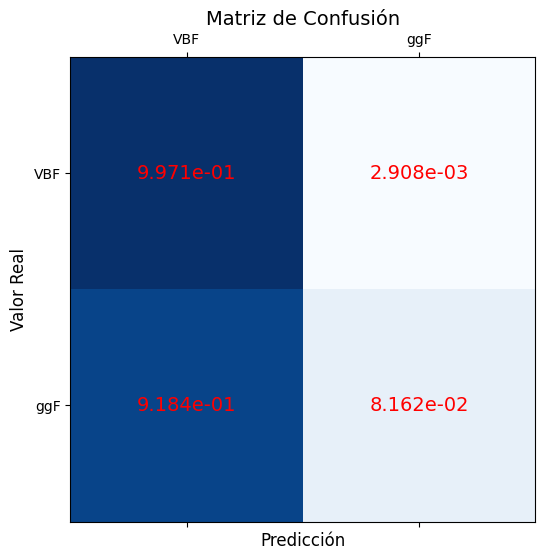

In [18]:
plot_matriz(matriz, porcentaje = True, normalizado=True)

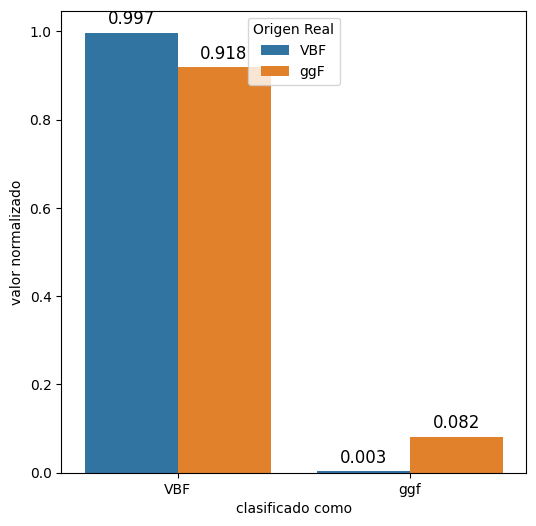

In [19]:
plot_confusion_barras(matriz)